In [ ]:
import pandas as pd

In [3]:
df1 = pd.read_csv('data.csv')
df2 = pd.read_csv('data_2genre.csv')
df = pd.concat([df1, df2])

In [4]:
genres = []

for _ in df['filename']:
    genres.append(_[:-9])

df.insert(1, 'genre', genres)

In [4]:
# bins = [45, 66, 76, 108, 120,
#        156, 176, 200, 235
# ]
# labels = ['Largo', 'Adagio', 'Andante',
#          'Moderato', 'Allegro', 'Vivace',
#          'Presto', 'Prestissimo'
# ]
# df['Tempo Markings'] = pd.cut(df['tempo'], bins=bins, labels=labels)

In [5]:
df = df[['genre', 'beats', 'chroma_stft', 'rmse',
       'spectral_centroid', 'spectral_bandwidth', 'rolloff',
       'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5',
       'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19',
       'mfcc20']]
df.head()

,genre,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,blues,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,107.334008,...,-15.234050,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987
1,blues,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,136.170239,...,5.145258,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485
2,blues,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,110.843070,...,-26.406674,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260
3,blues,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,132.799175,...,-2.452068,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607
4,blues,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,102.829023,...,-6.934599,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315


In [7]:
!pip install pandas-profiling

In [26]:
df['genre'].unique()

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.8, test_size=0.2, random_state=42)

In [7]:
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=42)

In [7]:
!pip install category-encoders

In [1]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

In [8]:
def wrangle(train, val, test):
    
    X_train = train.drop(columns='genre')
    y_train = train['genre']
    X_val = val.drop(columns='genre')
    y_val = val['genre']
    X_test = test.drop(columns='genre')
    
    encoder = ce.OrdinalEncoder()

    y_train = encoder.fit_transform(y_train)
    y_val = encoder.transform(y_val)
    
    return X_train, y_train, X_val, y_val, X_test

In [9]:
X_train, y_train, X_val, y_val, X_test = wrangle(train, val, test)

In [10]:
for df in X_train, y_train, X_val, y_val, X_test:
    print(df.shape)

(768, 27)
(768, 1)
(192, 27)
(192, 1)
(240, 27)


In [11]:
# Base LogReg model - Good
import numpy as np
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', multi_class='ovr')

model.fit(X_train, np.ravel(y_train))
print('Validation Accuracy', model.score(X_val, np.ravel(y_val)))

Validation Accuracy 0.640625


In [13]:
from sklearn.pipeline import make_pipeline

# Validation Accuracy with StandardScaler - Better!
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear', multi_class='ovr')
)
pipeline.fit(X_train, np.ravel(y_train))
print('Validation Accuracy', pipeline.score(X_val, np.ravel(y_val)))

Validation Accuracy 0.6875


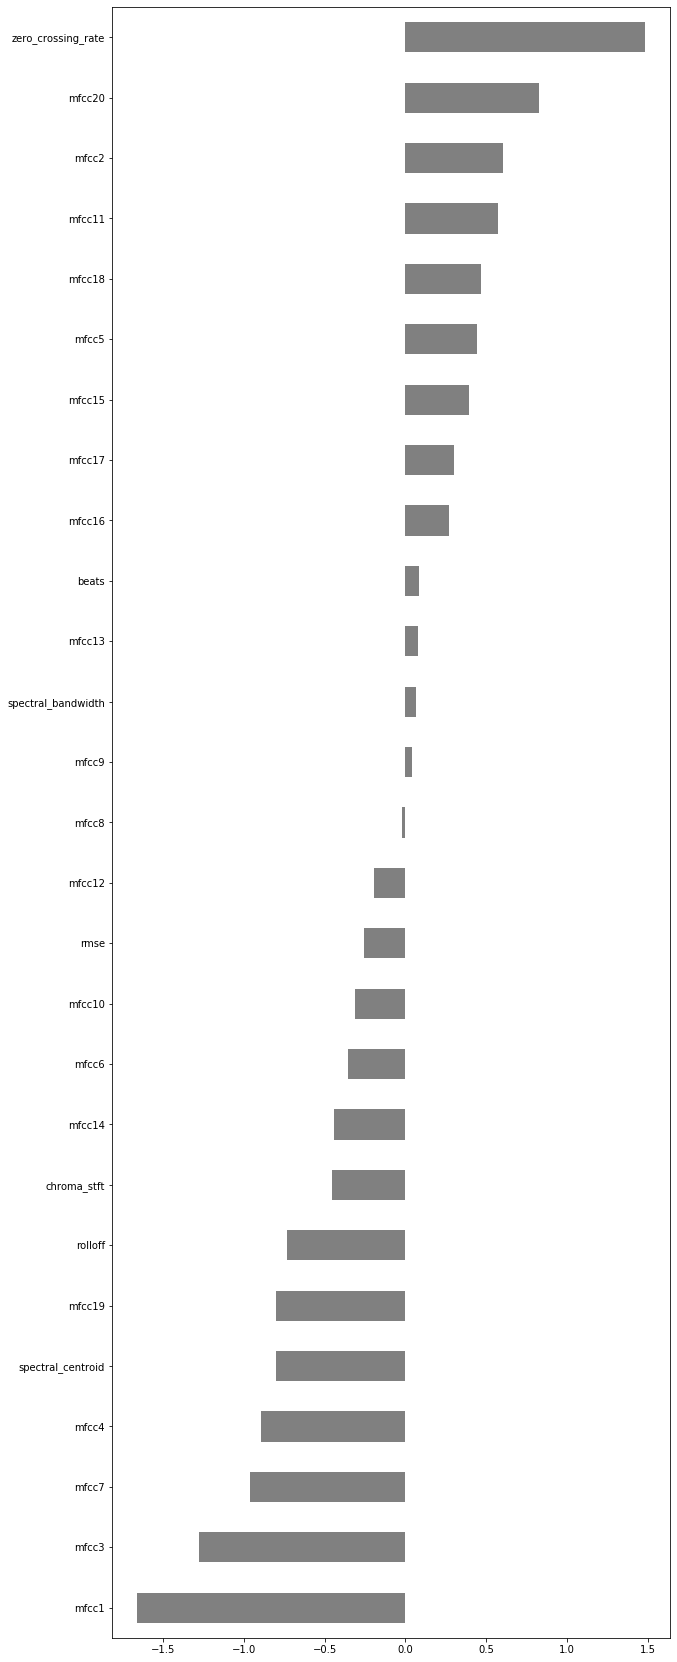

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
scaler = pipeline.named_steps['standardscaler']
coefficients = pd.Series(model.coef_[0], X_val.columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
# Decision Tree with default attributes - Worse
pipeline = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)
pipeline.fit(X_train, np.ravel(y_train))
print('Validation Accuracy with Decision Tree at Default:', pipeline.score(X_val, np.ravel(y_val)))

Validation Accuracy with Decision Tree at Default: 0.6041666666666666


In [33]:
# Decision Tree Regressor - BAD
from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(
    StandardScaler(),
    DecisionTreeRegressor(random_state=42)
)
pipeline.fit(X_train, np.ravel(y_train))
print('Validation Accuracy with Decision Tree Regressor at Default:', pipeline.score(X_val, np.ravel(y_val)))

Validation Accuracy with Decision Tree Regressor at Default: 0.034446921109849926


In [46]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

feature = 'mfcc9'

lr = make_pipeline( 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='ovr', solver='liblinear', cv=5)
)

lr.fit(X_train[[feature]], np.ravel(y_train))
score = lr.score(X_val[[feature]], np.ravel(y_val))
print('Logistic Regression, Validation Accuracy', score)

Logistic Regression, Validation Accuracy 0.3125


In [49]:
from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    DecisionTreeClassifier(random_state=42)
)

dt.fit(X_train, np.ravel(y_train))
score = dt.score(X_val, np.ravel(y_val))
print('Decision Tree, Validation Accuracy', score)

Decision Tree, Validation Accuracy 0.6041666666666666


In [50]:
import graphviz
from sklearn.tree import export_graphviz

model = dt.named_steps['decisiontreeclassifier']
dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=7, 
                           feature_names=X_train.columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

TypeError: can only concatenate str (not "numpy.int64") to str

In [55]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest Model with defaults - Slightly better than LogReg baseline
# With n_estimators=100 gives best accuracy so far
pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)
pipeline.fit(X_train, np.ravel(y_train))
print('Random Forest Val Accuracy with Defaults:', pipeline.score(X_val, np.ravel(y_val)))

Random Forest Val Accuracy with Defaults: 0.71875


In [66]:
target = 'genre'

features = X_train.columns

X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

k=3
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring='accuracy')
print(f'Accuracy for {k} folds:', scores)

Accuracy for 3 folds: [0.65384615 0.64705882 0.68774704]


In [67]:
scores.mean()

0.6628840043162294

In [ ]:
# I'm going to save whomever tries to run this code a
# Lot of time by commenting out the two separate times
# In which I ran Cross-Validation tests totaling 2000 fits

In [80]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from scipy.stats import randint, uniform

# param_distributions = {
#     'standardscaler__with_mean': [True, False],
#     'standardscaler__with_std': [True, False],
#     'randomforestclassifier__n_estimators': randint(50,500),
#     'randomforestclassifier__max_depth': [5,10,15,20,None],
#     'randomforestclassifier__max_features': [None, 'auto', 'log2'],
# }

# search = RandomizedSearchCV(
#     pipeline,
#     param_distributions=param_distributions,
#     n_iter=100,
#     cv=10,
#     scoring='accuracy',
#     verbose=10,
#     return_train_score=True,
#     n_jobs=-1
# )

# search.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

In [81]:
print('Best hyperparameters', search.best_params_)
print('Cross-Validation Accuracy Score', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': None, 'randomforestclassifier__n_estimators': 350, 'standardscaler__with_mean': True, 'standardscaler__with_std': True}
Cross-Validation Accuracy Score 0.69921875


In [82]:
# param_distributions = {
#     'standardscaler__with_mean': [True, False],
#     'standardscaler__with_std': [True, False],
#     'randomforestclassifier__n_estimators': randint(50,500),
#     'randomforestclassifier__max_depth': [5,10,15,20,None],
#     'randomforestclassifier__max_features': uniform(0,1),
# }

# search2 = RandomizedSearchCV(
#     pipeline,
#     param_distributions=param_distributions,
#     n_iter=100,
#     cv=10,
#     scoring='accuracy',
#     verbose=10,
#     return_train_score=True,
#     n_jobs=-1
# )

# search2.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  5

In [83]:
print('Best hyperparameters', search2.best_params_)
print('Cross-Validation Accuracy Score', search2.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 0.6112867097534939, 'randomforestclassifier__n_estimators': 139, 'standardscaler__with_mean': True, 'standardscaler__with_std': False}
Cross-Validation Accuracy Score 0.7005208333333334


In [ ]:
# Unfortunately altering the parameters and running so many fits
# Still could not beat my basic Random Forest model's accuracy
# Of %71.875

In [98]:
y_pred = search.predict(X_val)

In [99]:
y_val = val['genre']

In [100]:
import seaborn as sns

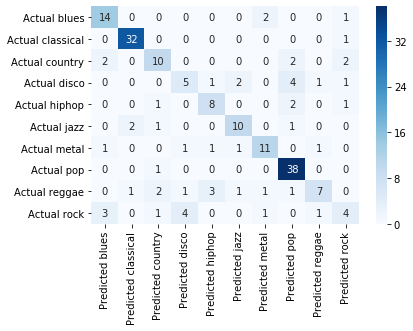

In [102]:
# Confusion Matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    df = pd.DataFrame(confusion_matrix(y_true, y_pred),
                     columns=columns, index=index)
    return sns.heatmap(df, annot=True, fmt='d', cmap='Blues')

# Confusion Matrix from model fitted in CV search
plot_confusion_matrix(y_val, y_pred);

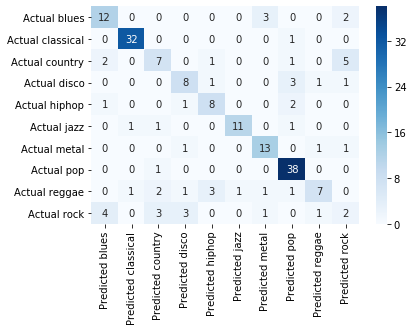

In [104]:
# Confusion Matrix with 71% accuracy from Random Forest
pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)
pipeline.fit(X_train, np.ravel(y_train))

y_pred = pipeline.predict(X_val)
plot_confusion_matrix(y_val, y_pred);

In [105]:
pipeline_SS = make_pipeline(
    StandardScaler()
)

X_train_transformed = pipeline_SS.fit_transform(X_train)
X_val_transformed = pipeline_SS.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [107]:
!pip install eli5

     |████████████████████████████████| 112kB 548kB/s eta 0:00:01
     |████████████████████████████████| 51kB 1.3MB/s eta 0:00:01
  Stored in directory: /home/jb8268/.cache/pip/wheels/9c/9b/f4/eb243fdb89676ec00588e8c54bb54360724c06e7fafe95278e
Successfully built tabulate


In [108]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [109]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.0677 ± 0.0247,chroma_stft
0.0385 ± 0.0214,mfcc4
0.0365 ± 0.0456,rmse
0.0344 ± 0.0193,mfcc17
0.0281 ± 0.0156,mfcc9
0.0240 ± 0.0243,mfcc1
0.0198 ± 0.0042,beats
0.0198 ± 0.0078,mfcc11
0.0198 ± 0.0121,mfcc6
0.0188 ± 0.0169,mfcc20


In [110]:
# Removing features of minimal importance
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_minim = X_train[features]
print(f'Shape after removing features:', X_train_minim.shape)

Shape after removing features: (768, 25)


In [112]:
X_val_minim = X_val[features]

pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)
pipeline.fit(X_train_minim, np.ravel(y_train))
print('Validation Accuracy after feature removal:', pipeline.score(X_val_minim, np.ravel(y_val)))

Validation Accuracy after feature removal: 0.71875


In [ ]:
# Unfortunately, even after removing the two features, the Validation accuracy
# Did not budge which means they are probably very insignificant